This module allows the students to visualize and analyse atomic and molecular orbitals, build molecular diagrams.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import integrate, special
from pyscf import gto, scf, adc, lib

/Users/milaimkas/Teaching/Teaching_project/venv/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
def Psi(n,l,m,r,phi,thet,Z):
    '''
    Hydrogen-like wavefunction
    
    n: principal quantum number
    l: azimuthal quantum number
    m: magnetic quantum number
    r, phi and thet: spherical coordinates
    Z: nuclear charge
    
    return the total wave function Psi, the radial part R and the angular part Y
    '''

    # angular part -> spherical harmonics
    Y = special.sph_harm(m,l,thet,phi)

    # radial part containing the associated Laguerre polynomials
    R = np.sqrt((math.factorial(n-l-1)*(2*Z/n)**3)/(2*n*math.factorial(n+l)))
    R *= (2*r*Z/n)**l
    R *= np.exp(-Z*r/n)
    x = 2*r*Z/n
    R *= special.assoc_laguerre(x,n-l-1,2*l+1)

    psi = Y*R

    return R, Y

In [4]:
class get_orb():
    """
    Molecular and IP Dyson orbital for closed-shell atom
    """

    def __init__(self, atm):
        
        self.mol = gto.M(atom=atm, basis='aug-cc-pvdz')
        self.mol.spin = 0
        self.mf = scf.RHF(self.mol)
        self.mf.run()
    
    def get_mo(self,idx):
        return self.mf.mo_coeff[:, idx].flatten()
        
    def get_dyson_ip(self):

        myadc = adc.ADC(self.mf)
        myadc.method = "adc(3)"
        myadc.method_type = "ip"
        myadc.kernel(nroots=1)

        dyson_orb = myadc.compute_dyson_mo()

        return dyson_orb.flatten()


    def get_orb_coord(self, coeff, rf, rn, tn, pn):

        dim = rn * tn * pn
        if dim > 8000:
            raise ValueError("Number of grid points too large")

        # get spherical coord
        R = np.linspace(0, rf, rn)
        T = np.linspace(0, 2*np.pi, tn)
        P = np.linspace(0, np.pi, pn)
        coords_sphe = lib.cartesian_prod([R, T, P])  # dim x 3 array corresponding to coordinates

        # transform into cart coord
        coords_cart = np.zeros_like(coords_sphe)  #
        coords_cart[:, 0] = coords_sphe[:, 0] * np.sin(coords_sphe[:, 2]) * np.cos(coords_sphe[:, 1])  # x
        coords_cart[:, 1] = coords_sphe[:, 0] * np.sin(coords_sphe[:, 2]) * np.sin(coords_sphe[:, 1])  # y
        coords_cart[:, 2] = coords_sphe[:, 0] * np.cos(coords_sphe[:, 2])                              # z

        # Compute density
        ao = self.mol.eval_gto("GTOval", coords_cart)
        orb_on_coord = np.dot(ao, coeff)

        return orb_on_coord, coords_cart, coords_sphe

        


In [9]:
my_orb_Ne = get_orb('Ne')
mo_1s = my_orb_Ne.get_mo(0)
mo_2pz = my_orb_Ne.get_mo(2)


converged SCF energy = -128.496349730541


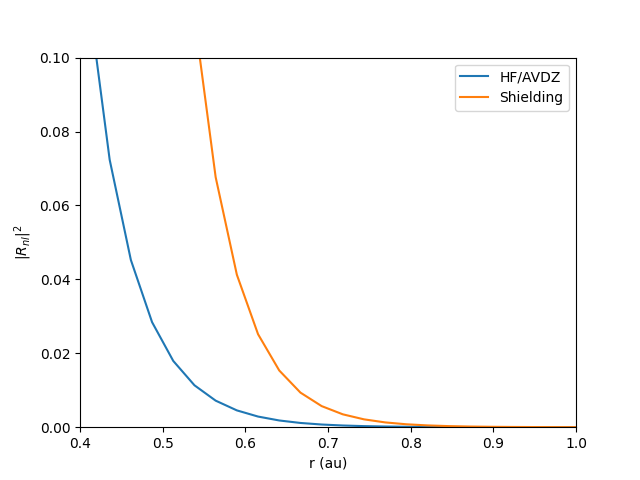

In [10]:
orb, coord_cart, coord_sph = my_orb_Ne.get_orb_coord(mo_1s, 1.0, 40, 1, 1)

%matplotlib widget
Ne_1s = abs(Psi(1,0,0,coord_sph[:,0],0,0,9.642)[0])**2
plt.plot(coord_sph[:,0], abs(orb)**2, label="HF/AVDZ")
plt.plot(coord_sph[:,0], Ne_1s, label="Shielding")
plt.xlabel("r (au)")
plt.ylabel("$|R_{nl}|^2$")
plt.legend()
plt.ylim(0,0.1)
plt.xlim(0.4,1)
plt.show()

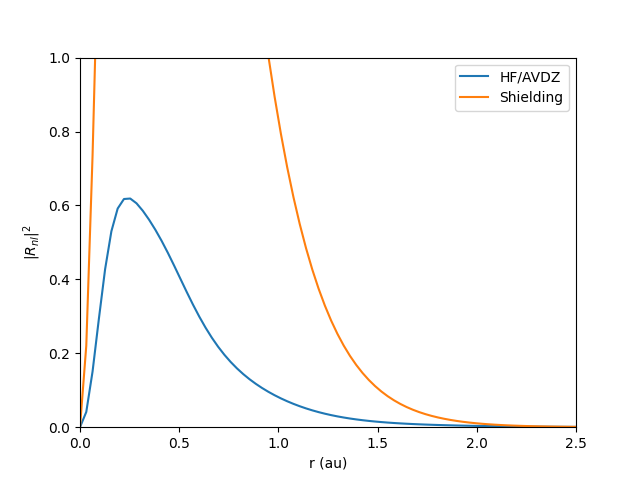

In [11]:
orb, coord_cart, coord_sph = my_orb_Ne.get_orb_coord(mo_2pz, 2.5, 80, 1, 1)

%matplotlib widget
Ne_2pz = abs(Psi(2,1,0,coord_sph[:,0],0,0,5.76)[0])**2
plt.plot(coord_sph[:,0], abs(orb)**2, label="HF/AVDZ")
plt.plot(coord_sph[:,0], Ne_2pz, label="Shielding")
plt.xlabel("r (au)")
plt.ylabel("$|R_{nl}|^2$")
plt.legend()
plt.ylim(0,1.)
plt.xlim(0,2.5)
plt.show()